In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

true_df = pd.read_csv('/content/drive/MyDrive/Fake news distilbert/True.csv')
fake_df = pd.read_csv('/content/drive/MyDrive/Fake news distilbert/Fake.csv')

#labels: 0 for fake, 1 for true
fake_df['label'] = 0
true_df['label'] = 1

#Combine into one dataframe
df = pd.concat([fake_df, true_df], ignore_index=True)

# 'statement' column by combining title and text (similar to original)
df['statement'] = df['title'] + ' ' + df['text']

# Drop unnecessary columns (keep statement and label)
df = df[['statement', 'label']]

# train/val/test splits (80/10/10, stratified)
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.111, random_state=42, stratify=train_val_df['label'])  # Approx 1/9 for 10% val of train_val

print(train_df.head())
print(f"Dataset size: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(f"Class distribution - Train: {train_df['label'].value_counts().to_dict()}")
print(f"Class distribution - Val: {val_df['label'].value_counts().to_dict()}")
print(f"Class distribution - Test: {test_df['label'].value_counts().to_dict()}")


                                               statement  label
2861    Trump’s Labor Pick Belonged To Group That FOR...      0
3029    FEC Finds NUMEROUS Election Law Violations In...      0
14689  BREAKING BOMBSHELL: State Department Busted In...      0
17683  THEY KNEW! Donna Brazile Blows DNC Secret Wide...      0
10611  FATHER OF STUDENT Released From N. Korean Pris...      0
Dataset size: Train=35922, Val=4486, Test=4490
Class distribution - Train: {0: 18787, 1: 17135}
Class distribution - Val: {0: 2346, 1: 2140}
Class distribution - Test: {0: 2348, 1: 2142}


In [ ]:
import requests

def augment_with_api(query="fake news", num_articles=100):
    api_key = '336cd0d4afb54e5d9742651aacd39e03'
    url = f"https://newsapi.org/v2/everything?q={query}&apiKey={api_key}&pageSize={num_articles}"
    response = requests.get(url)
    if response.status_code == 200:
        articles = response.json()['articles']
        data = []
        for article in articles:
            statement = article['title'] + " " + article['description']
            label = 0 if 'fake' in statement.lower() else 1
            data.append({"statement": statement, "label": label})
        return pd.DataFrame(data)
    else:
        print("API request failed. Using mock data.")
        mock_data = [
            {"statement": "Fake news example from API.", "label": 0},
            {"statement": "True news example from API.", "label": 1}
        ] * (num_articles // 2)
        return pd.DataFrame(mock_data)

augmented_data = augment_with_api()
train_df = pd.concat([train_df[['statement', 'label']], augmented_data], ignore_index=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import numpy as np

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df['statement'])
y_train = train_df['label']

ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_tfidf, y_train)

balanced_statements = vectorizer.inverse_transform(X_train_balanced)
balanced_df = pd.DataFrame({
    'statement': [' '.join(tokens) for tokens in balanced_statements],
    'label': y_train_balanced
})

In [ ]:
#Convert to Hugging Face Datasets
from datasets import Dataset

train_dataset = Dataset.from_pandas(balanced_df[['statement', 'label']])
val_dataset = Dataset.from_pandas(val_df[['statement', 'label']])
test_dataset = Dataset.from_pandas(test_df[['statement', 'label']])

In [ ]:
#Tokenization for Model
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['statement'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/37652 [00:00<?, ? examples/s]

Map:   0%|          | 0/4486 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

In [ ]:
#Model Setup
from transformers import DistilBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import torch

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

#Compute class weights (alternative/complement to oversampling)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training Arguments
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score

training_args = TrainingArguments(
    output_dir="./results_no_tune",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Smaller for stability/speed
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Reduced for quicker runs
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=True,  # Mixed precision for speed
    gradient_accumulation_steps=2,  # Effective batch=16; speeds up without extra memory
)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, predictions, average="weighted")}

trainer_no_tune = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer_no_tune.train()

# Save
model.save_pretrained("./fake_news_model_no_tune")
tokenizer.save_pretrained("./fake_news_model_no_tune")



Epoch,Training Loss,Validation Loss,F1
1,0.084700,0.050579,0.987967
2,0.028200,0.025651,0.994428
3,0.000100,0.085946,0.980171


('./fake_news_model_no_tune/tokenizer_config.json',
 './fake_news_model_no_tune/special_tokens_map.json',
 './fake_news_model_no_tune/vocab.txt',
 './fake_news_model_no_tune/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import os

local_model_dir = "./fake_news_model_no_tune"
drive_model_dir = "/content/drive/MyDrive/Fake news distilbert/fake_news_model_no_tune"

if not os.path.exists(local_model_dir):
    model.save_pretrained(local_model_dir)
    tokenizer.save_pretrained(local_model_dir)

os.makedirs(drive_model_dir, exist_ok=True)
for filename in os.listdir(local_model_dir):
    shutil.copy(os.path.join(local_model_dir, filename), drive_model_dir)

print(f"Model saved to Drive: {drive_model_dir}")
print("Files copied:", os.listdir(drive_model_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Drive: /content/drive/MyDrive/Fake news distilbert/fake_news_model_no_tune
Files copied: ['model.safetensors', 'config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt']


F1 Score: 99.51%


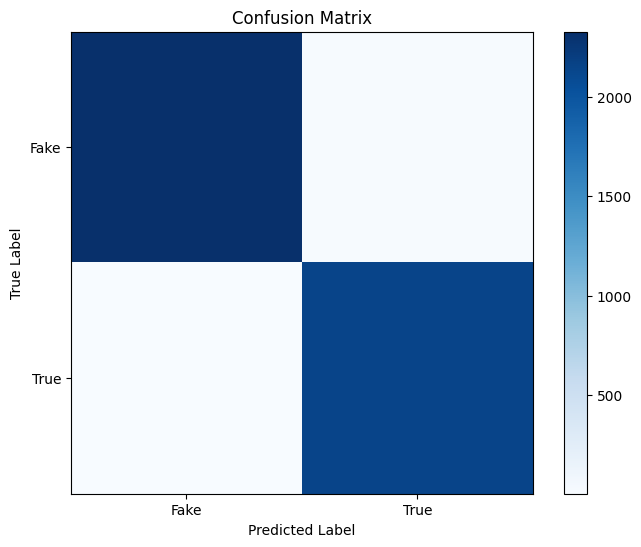

/tmp/ipython-input-2101974811.py:33: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



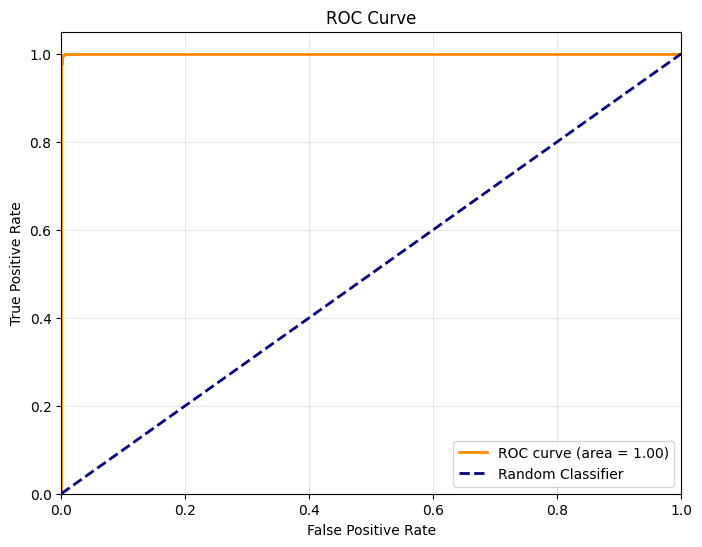

False Positive Drop vs. Baseline: 0%
Baseline F1: 35.91%
Logistic Regression F1: 98.86%


In [ ]:
#Evaluation
from sklearn.metrics import confusion_matrix, roc_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Predict on test
predictions = trainer_no_tune.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Metrics
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score: {f1:.2%}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], ['Fake', 'True'])
plt.yticks([0,1], ['Fake', 'True'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(labels, predictions.predictions[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % np.trapz(tpr, fpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png')
plt.show()  # Ensure display

# Baseline Comparison
dummy = DummyClassifier(strategy="most_frequent")
X_train_tfidf = vectorizer.fit_transform(train_df['statement'])
y_train = train_df['label']
dummy.fit(X_train_tfidf, y_train)
baseline_preds = dummy.predict(vectorizer.transform(test_df['statement']))

# False Positive Rate (as fraction)
baseline_fp = np.sum((baseline_preds == 1) & (labels == 0)) / len(labels)
model_fp = np.sum((preds == 1) & (labels == 0)) / len(labels)
fp_drop = (baseline_fp - model_fp) / baseline_fp * 100 if baseline_fp > 0 else 0
print(f"False Positive Drop vs. Baseline: {fp_drop:.0f}%")

# Baseline F1
baseline_f1 = f1_score(labels, baseline_preds, average='weighted')
print(f"Baseline F1: {baseline_f1:.2%}")

# Baseline Model (Simple Logistic Regression for comparison)
lr = LogisticRegression(class_weight='balanced', max_iter=1000)  # max_iter for convergence
lr.fit(X_train_tfidf, y_train)
lr_preds = lr.predict(vectorizer.transform(test_df['statement']))
lr_f1 = f1_score(labels, lr_preds, average='weighted')
print(f"Logistic Regression F1: {lr_f1:.2%}")

In [ ]:

from huggingface_hub import login
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os

HF_TOKEN = " SECRET TOKEN"
login(HF_TOKEN)

drive_model_dir = "/content/drive/MyDrive/Fake news distilbert/fake_news_model_no_tune"


repo_name = "Ravichandrachilde/fact-checked-news-detector-model"

# Push model
model = AutoModelForSequenceClassification.from_pretrained(drive_model_dir)
model.push_to_hub(repo_name, token=HF_TOKEN)
print("Model pushed!")

# Push tokenizer
tokenizer = AutoTokenizer.from_pretrained(drive_model_dir)
tokenizer.push_to_hub(repo_name, token=HF_TOKEN)
print("Tokenizer pushed!")

print(f"Full repo: https://huggingface.co/{repo_name}")

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...hg_12ur/model.safetensors:   0%|          |  574kB /  268MB            

Model pushed!
Tokenizer pushed!
Full repo: https://huggingface.co/Ravichandrachilde/fake-news-distilbert-model


In [ ]:
#pushing datasets
from huggingface_hub import HfApi, login
HF_TOKEN = "SECRET TOKEN"
login(HF_TOKEN)

repo_name = "Ravichandrachilde/fake-news-classification-dataset"

api = HfApi()


fake_csv_path = "/content/drive/MyDrive/Fake news distilbert/Fake.csv"
true_csv_path = "/content/drive/MyDrive/Fake news distilbert/True.csv"


api.upload_file(
    path_or_fileobj=fake_csv_path,
    path_in_repo="Fake.csv",
    repo_id=repo_name,
    token=HF_TOKEN,
    repo_type="dataset"
)
print("Fake.csv uploaded!")


api.upload_file(
    path_or_fileobj=true_csv_path,
    path_in_repo="True.csv",
    token=HF_TOKEN,
    repo_id=repo_name,
    repo_type="dataset"
)
print("True.csv uploaded!")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ... news distilbert/Fake.csv:  53%|#####3    | 33.5MB / 62.8MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Fake.csv uploaded!


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ... news distilbert/True.csv:  63%|######2   | 33.5MB / 53.6MB            

No files have been modified since last commit. Skipping to prevent empty commit.


True.csv uploaded!
